# Quantum Optimal Control through Bayesian Optimisation on fidelity
### Preparation of the Greenberger–Horne–Zeilinger state (GHZ state)


In this notebook we address the task of creating the GHZ state $\frac{|000\rangle +|111\rangle}{\sqrt{2}}$ by optimising on the fidelity

In [1]:
#Import libraries
import torch
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
import numpy as np
from math import pi
import matplotlib.pylab as plt
from itertools import product
from qiskit.quantum_info import Operator
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(1, '../src/')
from utils.functions import *
from models.models_bo import *



In this cell, we define the quantum circuit designed to prepare the target GHZ state. You can also modify the target state and the initial state directly within this cell, allowing for flexibility in the setup. <br />
The fidelity is represented with a single surrogate model

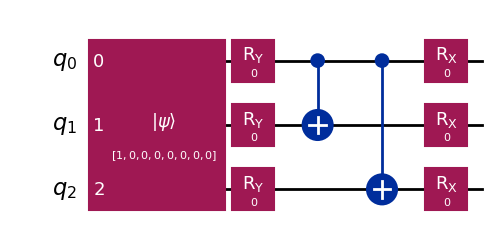

In [2]:
def create_controlled_ghz_circuit(thetas, initial_state):
  
    circ = QuantumCircuit(3)
    # Initialize qubits with the specified state
    circ.initialize(initial_state, [0,1,2])
    
    # Apply parameterized rotation gates
    circ.ry(thetas[0,0], 0)
    circ.ry(thetas[0,1], 1)
    circ.ry(thetas[0,2], 2)
    circ.cx(0, 1)
    circ.cx(0, 2)
    circ.rx(thetas[0,3], 0)
    circ.rx(thetas[0,4], 1)
    circ.rx(thetas[0,5], 2)

    return circ
target_state = np.array([1 , 0, 0, 0, 0, 0, 0, 1])/np.sqrt(2)
#target_state = np.array([1 , 0, 0, 0, 0, 0, 0, 1.01]) *np.sqrt((100**2)/((100**2 + 101**2))  )
initial_state = np.array([1, 0, 0, 0, 0, 0, 0, 0])
n_thetas = 6 #Number of parameters


ghz_visualization = create_controlled_ghz_circuit(np.zeros(n_thetas)[np.newaxis,:],initial_state)
coefficients, num_qubits = get_coefficients(target_state, ghz_visualization.num_qubits)
coefficients_array = np.array([coefficients[k] for k in list(coefficients.keys())])

ghz_visualization.draw('mpl')

In [3]:
ghz_contr_circuit = create_controlled_ghz_circuit
n_surrogates_models = len(coefficients)

#If you want to estimate the performance with a set of test of the surrogate models, it is recommended to use the lines that contain the word "test"
#they are commented to reduce the computational cost.
#n_test_samples = 100
#X_test, y_test_expectation_values, y_test_fidelities = get_real_samples(ghz_contr_circuit, n_test_samples, n_thetas, initial_state, target_state)


Main parameters of the BO

In [4]:
#Generate initial samples
n_initial_samples = 1
#Number of time to run the BO
n_run = 10

#Number of iterations of one BO
n_BO = 200


#Parameter of the function of adquisicion
beta = 1

In [5]:
#BO loop

history_best_fidelity_runs = np.zeros((n_run,n_BO)) #metric fidelity during BO
best_fidelity_runs = np.zeros(n_run) #metric best fidelity
best_thetas_runs = np.zeros((n_run, n_thetas)) #best params
n_samples_acquisition_fx = 1000
#Parameters of the GP
params = {'training_iter': 10, 'learning_rate':0.1, 'initial_noise':1e-8, 'initial_lengthscale':0.9, 'initial_output_scale': 1, 'scaler_target': None, #'StandardScaler'
            'verbose':False }
bounds = torch.stack([torch.zeros(n_thetas), 2*pi*torch.ones(n_thetas)]) #Bounds angles

for iter_run in range(n_run):
    print('run ', iter_run+1)

    # We get the initial data, prior
    X_initial_thetas, _, fidelities_initial = get_real_samples(ghz_contr_circuit, n_initial_samples, n_thetas, initial_state, target_state, type_sampling='Random_Uniform')
    history_best_fidelity = []
    mean_metrics = {'mean_MSE_fidelity_train':np.zeros(n_BO),'mean_MSE_fidelity_test':np.zeros(n_BO),
                    'mean_loss_train':np.zeros(n_BO), 'mean_loss_test':np.zeros(n_BO)}
    history_thetas = np.zeros((n_BO,n_thetas))

    #Store real data
    X_train, y_train_fidelities = X_initial_thetas, fidelities_initial

    #train model and save variables of training
    surrogate_models = {'gp_model':[], 'likelihood':[], 'scaler_target':[]}
    gp_model, ll, metrics, scaler_y = train_surrogate_models_gp((X_train, y_train_fidelities, [], [], params))
    surrogate_models['gp_model'].append(gp_model)
    surrogate_models['likelihood'].append(ll)
    surrogate_models['scaler_target'].append(scaler_y)
    #metrics_models['model_'+str(j)] = metrics

    #Best fidelity
    idx_best_real_fidelity = np.argmax(y_train_fidelities)
    best_fidelity = y_train_fidelities[idx_best_real_fidelity]
    best_thetas = X_train[idx_best_real_fidelity]
    history_best_fidelity.append(best_fidelity)

    params_predict = {'scaler_target':scaler_y} 
    iter_BO = 0
    mean_metrics['mean_MSE_fidelity_train'][iter_BO] = metrics['MSE_train'][-1]
    #mean_metrics['mean_MSE_fidelity_test'][iter_BO] = metrics['MSE_test'][-1]
    mean_metrics['mean_loss_train'][iter_BO] = metrics['loss_train'][-1]
    #mean_metrics['mean_loss_test'][iter_BO] = metrics['loss_test'][-1]


    pbar = tqdm(range(1,n_BO))
    for iter_BO in pbar:
        # Generate new angles samples and Acquisition function
        wrapped_gp_model = WrappedGPyTorchModelMonoGP(gp_model)
        fx_acq = UpperConfidenceBound(wrapped_gp_model, beta=beta )
        fx_acq.model.eval()
        candidate, acq_value = optimize_acqf(
            acq_function=fx_acq,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=n_samples_acquisition_fx)
       
        #New angles
        new_sample = np.array(candidate).squeeze(0)


        #Get the fidelity for the proposed angle
        _, new_fid_real, _ = get_expectation_values(ghz_contr_circuit, new_sample[np.newaxis,:],initial_state, target_state) #Get the real values

        #Add new data to known X_rain, y_train_fidelities
        X_train = np.vstack((X_train,new_sample[np.newaxis,:]))
        y_train_fidelities = np.hstack((y_train_fidelities, new_fid_real))

        #Check if the new fidelity is best than the current best fidelity
        if new_fid_real>best_fidelity:
            best_fidelity = new_fid_real
            best_thetas = new_sample
            
        history_best_fidelity.append(best_fidelity)
        history_thetas[iter_BO] = best_thetas

        #Update the surrogate model
        gp_model, ll, metrics, scaler_y = train_surrogate_models_gp((X_train, y_train_fidelities, [], [], params))
        params_predict = {'scaler_target':scaler_y} 
        mean_metrics['mean_MSE_fidelity_train'][iter_BO] = metrics['MSE_train'][-1]
        #mean_metrics['mean_MSE_fidelity_test'][iter_BO] = metrics['MSE_test'][-1]
        mean_metrics['mean_loss_train'][iter_BO] = metrics['loss_train'][-1]
        #mean_metrics['mean_loss_test'][iter_BO] = metrics['loss_test'][-1]

        pbar.set_description('Current best infidelity {}'.format(np.round(1-best_fidelity, 9)))

    history_best_fidelity_runs[iter_run] = history_best_fidelity
    best_fidelity_runs[iter_run] = best_fidelity
    best_thetas_runs[iter_run] = best_thetas

run  1


  0%|          | 0/199 [00:00<?, ?it/s]

run  2


  0%|          | 0/199 [00:00<?, ?it/s]

run  3


  0%|          | 0/199 [00:00<?, ?it/s]

run  4


  0%|          | 0/199 [00:00<?, ?it/s]

run  5


  0%|          | 0/199 [00:00<?, ?it/s]

run  6


  0%|          | 0/199 [00:00<?, ?it/s]

run  7


  0%|          | 0/199 [00:00<?, ?it/s]

run  8


  0%|          | 0/199 [00:00<?, ?it/s]

run  9


  0%|          | 0/199 [00:00<?, ?it/s]

run  10


  0%|          | 0/199 [00:00<?, ?it/s]

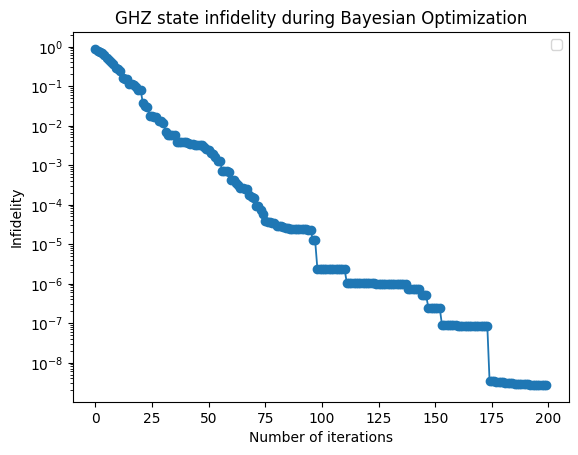

Mean best infidelity:  2.7320679052422747e-09


In [6]:
plt.plot(np.arange(n_BO),1-np.mean(np.array(history_best_fidelity_runs),0),'-o', linewidth=1.3)
plt.ylabel('Infidelity')
plt.xlabel('Number of iterations')
plt.yscale('log')
plt.title('GHZ state infidelity during Bayesian Optimization')
plt.legend()
plt.show()
print('Mean best infidelity: ', 1- np.mean(best_fidelity_runs))


In [8]:
#Save data generated
data_plot = {   'history_best_fidelity_runs':history_best_fidelity_runs,
                'best_thetas_runs': best_thetas_runs,
                'best_fidelity_runs':best_fidelity_runs, 
                'n_samples_acquisition_fx':n_samples_acquisition_fx,
                'n_BO': n_BO,
                'learning_rate': params['learning_rate'],
                'initial_noise': params['initial_noise'],
                'scaler_target': params['scaler_target'],
                'n_initial_samples': n_initial_samples,
                'mean_MSE_fidelity_train':mean_metrics['mean_MSE_fidelity_train'],
                'mean_loss_train': mean_metrics['mean_loss_train'],
                'type_acq_function': str(fx_acq), 
                'target_state': target_state,
             }

if True:
    
    with open("../results/qoc/results_ghz_bo_statevector.json", "w") as outfile: 
        json.dump(data_plot, outfile, cls=CustomEncoder)

In [9]:
metrics_reg= {
    'mean_infidelity_runs': 1- np.mean(best_fidelity_runs),
    'std_infidelity_runs': np.std(best_fidelity_runs),
        }

params['size_final_dataset'] = y_train_fidelities.shape[0]
params['n_samples_acquisition_fx'] = n_samples_acquisition_fx
params['type_acq_function'] = str(fx_acq)
params['n_initial_samples'] = n_initial_samples


Optionally: Track metrics and parameters in MLflow

In [10]:
import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("QOC_GHZ")

with mlflow.start_run(run_name='GHZ_BO_Statevector'):

    mlflow.log_params(params)
    mlflow.log_metrics(metrics_reg)

2024/09/20 16:21:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run GHZ_BO_Statevector at: http://127.0.0.1:8080/#/experiments/126759745047636218/runs/db7cd0d91a8143568854a6f1e8d44e43.
2024/09/20 16:21:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/126759745047636218.
